# Strain mapping with all calibrations
___

## 3B: Measure Bragg scattering - Scan and elliptical distortion measurement

Measure and correct and overall shifts of the diffraction patterns from the scanning of the beam.  Correct the elliptical distortions using the measurements performed on the calibration sample.
___

- Inputs:
  - Bragg peaks, uncorrected, for the experimental sample
- Outputs:
  - Bragg peaks, corrected, for the experimental sample
  - Bragg vector map, corrected, for the experimental sample

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter

# Diffraction shift correction
from py4DSTEM.process.calibration import get_diffraction_shifts, find_outlier_shifts, shift_braggpeaks
from py4DSTEM.process.fit import fit_2D
from py4DSTEM.process.braggdiskdetection import get_bragg_vector_map

# Elliptical distortion correction
from py4DSTEM.process.calibration import correct_elliptical_distortion

In [2]:
# Examine contents of processing_sampledata.h5

fp_processing = "/media/AuxDriveB/Data/20190904_StrainMappingExample_with_Calibrations/processing_sampledata.h5"
browser = py4DSTEM.file.io.FileBrowser(fp_processing)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    braggvectormap_calibrationdata_shiftcorrectedDiffractionSlice    
   1    braggvectormap_corrected_calibrationdataDiffractionSlice    
   2    braggvectormap_corrected_experiment DiffractionSlice    
   3    braggvectormap_experiment_shiftcorrectedDiffractionSlice    
   4    braggvectormap_uncorrected_calibrationdataDiffractionSlice    
   5    braggvectormap_uncorrected_experimentDiffractionSlice    
   6    probe                               DiffractionSlice    
   7    diffractionshifts_calibrationdata   RealSlice           
   8    diffractionshifts_experiment        RealSlice           
   9    virtual_image                       RealSlice           
   10   Qpixel_calibration                  PointList           
   11   RQ_rotational_offset_degrees        PointList           
   12   elliptical_distortion               PointList           
   13   braggpeaks_corrected_calibrationdataPointListArray      
 

In [3]:
# Load data

braggpeaks_uncorrected = browser.get_dataobject('braggpeaks_uncorrected_experiment')
braggvectormap_uncorrected = browser.get_dataobject('braggvectormap_uncorrected_experiment').data
ellipse_params = browser.get_dataobject('elliptical_distortion')
browser.close()

R_Nx,R_Ny = braggpeaks_uncorrected.shape
Q_Nx,Q_Ny = braggvectormap_uncorrected.shape

### Diffraction shifts

Here we measure and correct shifts of the diffraction patterns due to the scanning of the beam in real space.  We proceed as follows:

Measure diffraction shifts
- Get an initial guess at the diffraction shifts
- Find outliers in initial diffraction shift guesses
- Ignoring outliers, fit a plane or parabola to the initial guess.

Correct diffraction shifts
- Apply shifts to the Bragg peak positions

#### Measure diffraction shifts

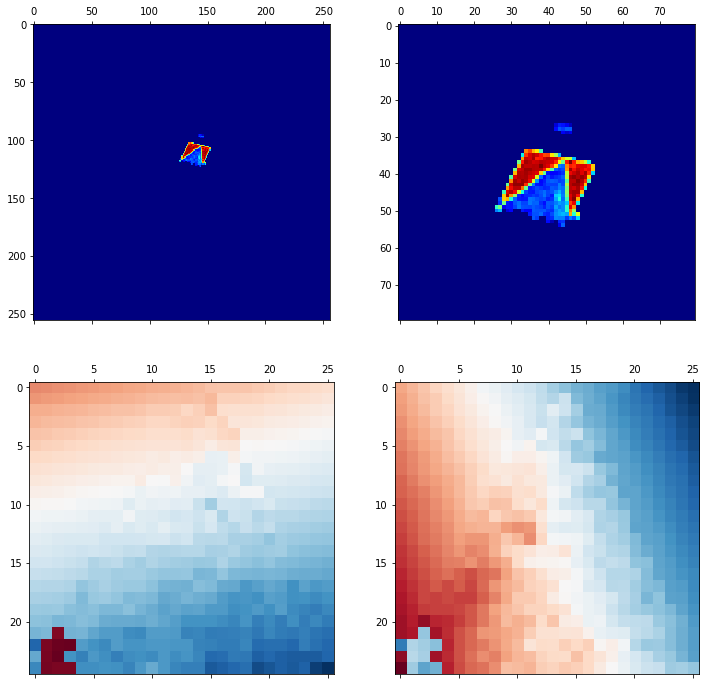

In [4]:
# Get diffraction shifts

findcenter = 'CoM'   # Must be 'CoM' or 'max'
rad = 40             # for display
power = 0.25

xshifts, yshifts, braggvectormap_center = get_diffraction_shifts(braggpeaks_uncorrected,
                                                                 Q_Nx, Q_Ny,
                                                                 findcenter=findcenter)

# Show
x0,y0 = py4DSTEM.process.utils.get_CoM(braggvectormap_center)

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))
ax11.matshow(braggvectormap_center**0.25,cmap='jet')
ax12.matshow(braggvectormap_center[int(x0-rad):int(x0+rad),int(y0-rad):int(y0+rad)]**power,cmap='jet')
ax21.matshow(xshifts,cmap="RdBu")
ax22.matshow(yshifts,cmap="RdBu")
plt.show()

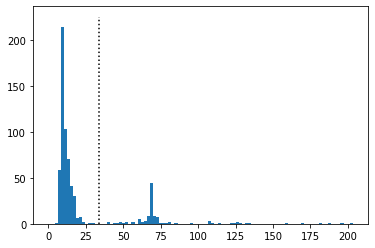

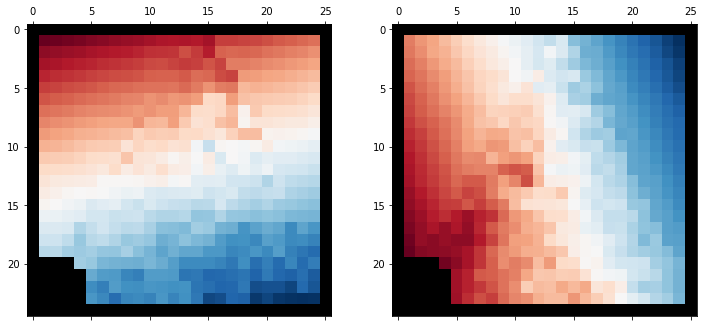

In [5]:
# Find outliers

n_sigma = 20
edge_boundary = 1
n_bins = 100

mask,n,bins,cutoff = find_outlier_shifts(xshifts,yshifts,n_sigma=n_sigma,edge_boundary=edge_boundary,n_bins=n_bins)

# Show
xshifts_masked = np.ma.masked_array(xshifts, mask)
yshifts_masked = np.ma.masked_array(yshifts, mask)
mask_display = np.ma.masked_array(mask, mask==False)

fig,ax = plt.subplots()
ax.bar(bins[:-1]+(bins[1]-bins[0])/2., n, (bins[1]-bins[0]), align='center')
ax.vlines(cutoff,0,ax.get_ylim()[1],linestyle=':')
plt.show()

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(xshifts_masked,cmap="RdBu")
ax2.matshow(yshifts_masked,cmap="RdBu")
ax1.matshow(mask_display)
ax2.matshow(mask_display)
plt.show()

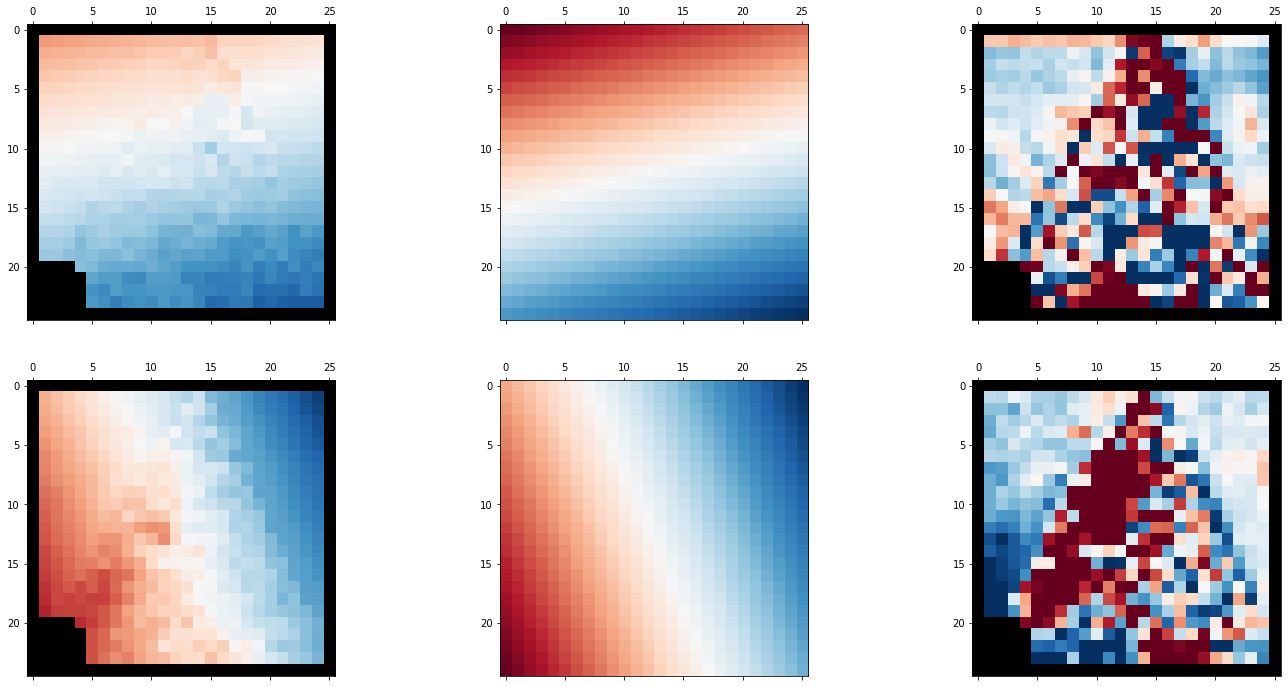

In [6]:
# Fit the diffraction shifts

#fit_function = py4DSTEM.process.fit.plane        # Select fit type
fit_function = py4DSTEM.process.fit.parabola

# Fit
xshifts_fit = np.zeros_like(xshifts)
yshifts_fit = np.zeros_like(yshifts)
popt_x, pcov_x, xshifts_fit = fit_2D(fit_function, xshifts, data_mask=mask==False)
popt_y, pcov_y, yshifts_fit = fit_2D(fit_function, yshifts, data_mask=mask==False)
residuals_x = xshifts-xshifts_fit
residuals_y = yshifts-yshifts_fit
residuals_x[mask] = 0
residuals_y[mask] = 0

# Show
fig,((ax11,ax12,ax13),(ax21,ax22,ax23))=plt.subplots(2,3,figsize=(24,12))
ax11.matshow(xshifts,cmap="RdBu")
ax21.matshow(yshifts,cmap="RdBu")
ax12.matshow(xshifts_fit,cmap="RdBu")
ax22.matshow(yshifts_fit,cmap="RdBu")
ax13.matshow(residuals_x,cmap="RdBu",vmin=np.median(residuals_x)-np.std(residuals_x),vmax=np.median(residuals_x)+np.std(residuals_x))
ax23.matshow(residuals_y,cmap="RdBu",vmin=np.median(residuals_y)-np.std(residuals_y),vmax=np.median(residuals_y)+np.std(residuals_y))
ax11.matshow(mask_display)
ax21.matshow(mask_display)
ax13.matshow(mask_display)
ax23.matshow(mask_display)
plt.show()

#### Correct diffraction shifts

In [7]:
# Apply shifts

braggpeaks_shiftcorrected = shift_braggpeaks(braggpeaks_uncorrected, xshifts_fit, yshifts_fit)

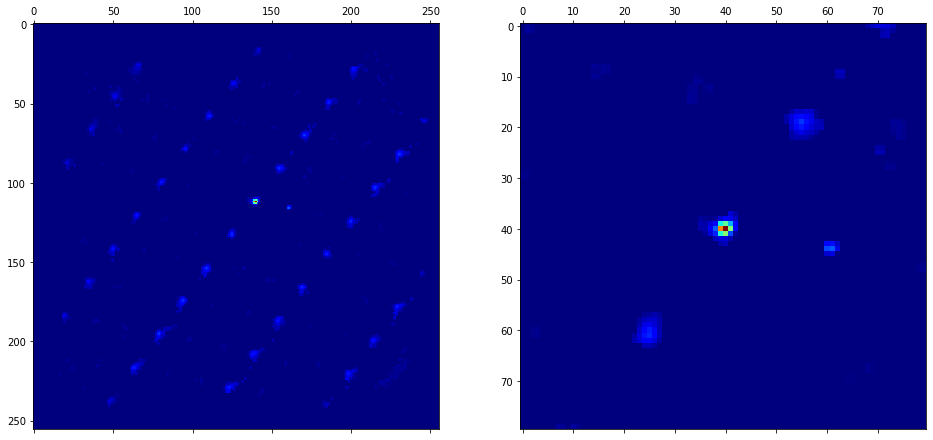

In [8]:
# Re-calculate Bragg vector map and show

braggvectormap_shiftcorrected = get_bragg_vector_map(braggpeaks_shiftcorrected,Q_Nx,Q_Ny)
power = 0.25

# Show
x0,y0=np.unravel_index(np.argmax(gaussian_filter(braggvectormap_shiftcorrected,2)),(Q_Nx,Q_Ny))
x0,y0=int(x0),int(y0)
rad=40

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
ax1.matshow(braggvectormap_shiftcorrected**0.25,cmap='jet')
ax2.matshow(braggvectormap_shiftcorrected[x0-rad:x0+rad,y0-rad:y0+rad]**power,cmap='jet')
plt.show()

### Save

In [10]:
# Store relevant data in  DataObjects

# Diffraction shifts
data = np.zeros((R_Nx,R_Ny,2))
data[:,:,0] = xshifts_fit
data[:,:,1] = yshifts_fit
diffractionshifts = py4DSTEM.file.datastructure.RealSlice(data, slicelabels=('x_shifts','y_shifts'), name='diffractionshifts_experiment')

# Corrected Bragg vector map
braggvectormap_diffslice = py4DSTEM.file.datastructure.DiffractionSlice(braggvectormap_shiftcorrected, name='braggvectormap_experiment_shiftcorrected')

In [13]:
# Append to processing file

dataobjects = [diffractionshifts, braggvectormap_diffslice]

py4DSTEM.file.io.append(dataobjects, fp_processing)

Opening file /media/AuxDriveB/Data/20190904_StrainMappingExample_with_Calibrations/processing_sampledata.h5...
Done.


### Correct elliptical distortion

Here we measure and correct elliptical distortion of the diffraction patterns due to imperfect electron optics, using the elliptical distortions measured from the calibration sample.

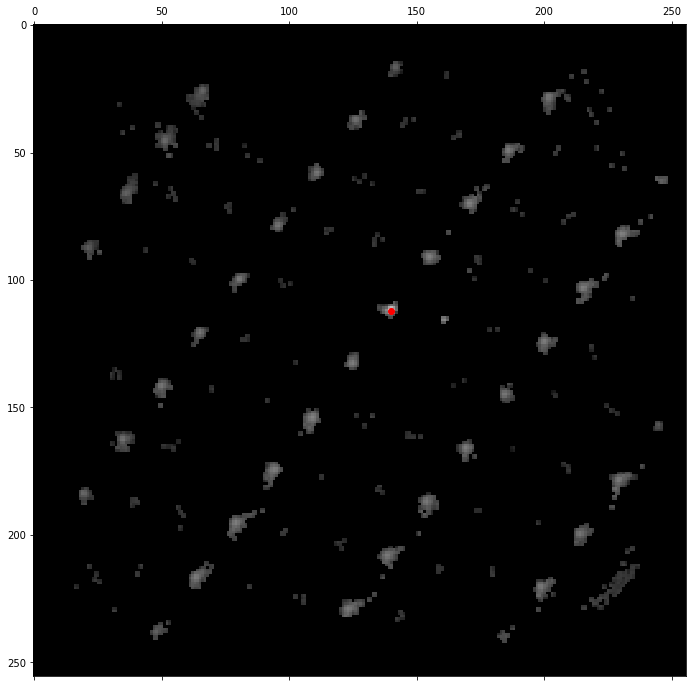

In [11]:
# Get optic axis position

r = 20
power = 0.1

bvm = py4DSTEM.process.braggdiskdetection.get_bragg_vector_map(braggpeaks_shiftcorrected,Q_Nx,Q_Ny)

x0,y0 = np.unravel_index(np.argmax(gaussian_filter(bvm,2)),(Q_Nx,Q_Ny))
yy,xx = np.meshgrid(np.arange(Q_Ny),np.arange(Q_Nx))
rr = np.hypot(xx-x0,yy-y0)
x0,y0 = py4DSTEM.process.utils.get_CoM(bvm*(rr<=r))

fig,ax = plt.subplots(figsize=(12,12))
ax.matshow(bvm**power)
ax.scatter(y0,x0,marker='o',color='r')
plt.show()

In [12]:
# Correct elliptical distortions

a = ellipse_params.data['a'][0]
b = ellipse_params.data['b'][0]
theta = ellipse_params.data['theta'][0]

corrected_ellipse_params = [x0,y0,a,b,theta]
braggpeaks_ellipsecorrected = correct_elliptical_distortion(braggpeaks_shiftcorrected, corrected_ellipse_params)

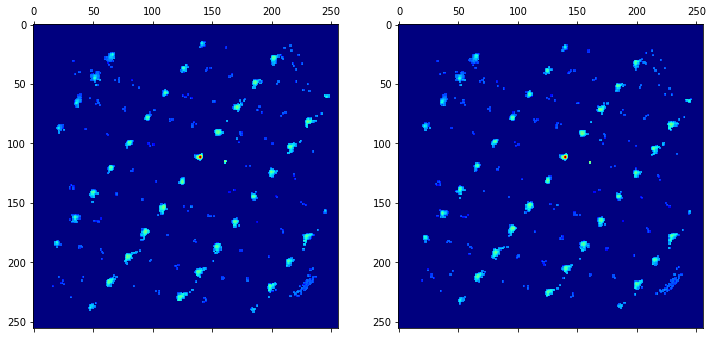

In [13]:
# Show

power = 0.1

bvm_c = py4DSTEM.process.braggdiskdetection.get_bragg_vector_map(braggpeaks_ellipsecorrected,Q_Nx,Q_Ny)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,12))
ax1.matshow(bvm**power,cmap='jet')
ax2.matshow(bvm_c**power,cmap='jet')
plt.show()

### Save

In [14]:
braggvectormap_corrected = py4DSTEM.file.datastructure.DiffractionSlice(data=bvm_c)
braggvectormap_corrected.name = 'braggvectormap_corrected_experiment'

braggpeaks_ellipsecorrected.name = 'braggpeaks_corrected_experiment'

In [27]:
append([braggpeaks_ellipsecorrected,braggvectormap_corrected],fp_processing)

Opening file /media/AuxDriveB/Data/20190904_StrainMappingExample_with_Calibrations/processing_sampledata.h5...
Done.
